LOAD and EXPLORE the data

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

%matplotlib inline
random_state = 15

data_url = "ML-Python-Lab-Data.csv"
target = 'Rings'

In [144]:
#load our data file as a pandas dataframe
df = pd.read_csv(data_url , sep = ',',header=None)
#show shape
print("Shape of the input data {}".format(df.shape))

Shape of the input data (4177, 10)


In [145]:
#header was not inside the file, let's add the column names provided in the file
df.columns = ['Index','Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']

In [146]:
#df description, could also use .head method
df.describe

<bound method NDFrame.describe of       Index Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0         0   M   0.455     0.365   0.095        0.5140          0.2245   
1         1   M   0.350     0.265   0.090           NaN          0.0995   
2         2   F   0.530     0.420   0.135           NaN          0.2565   
3         3   M   0.440     0.365   0.125        0.5160          0.2155   
4         4   I   0.330     0.255   0.080        0.2050          0.0895   
...     ...  ..     ...       ...     ...           ...             ...   
4172   4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings  
0             0.1010 

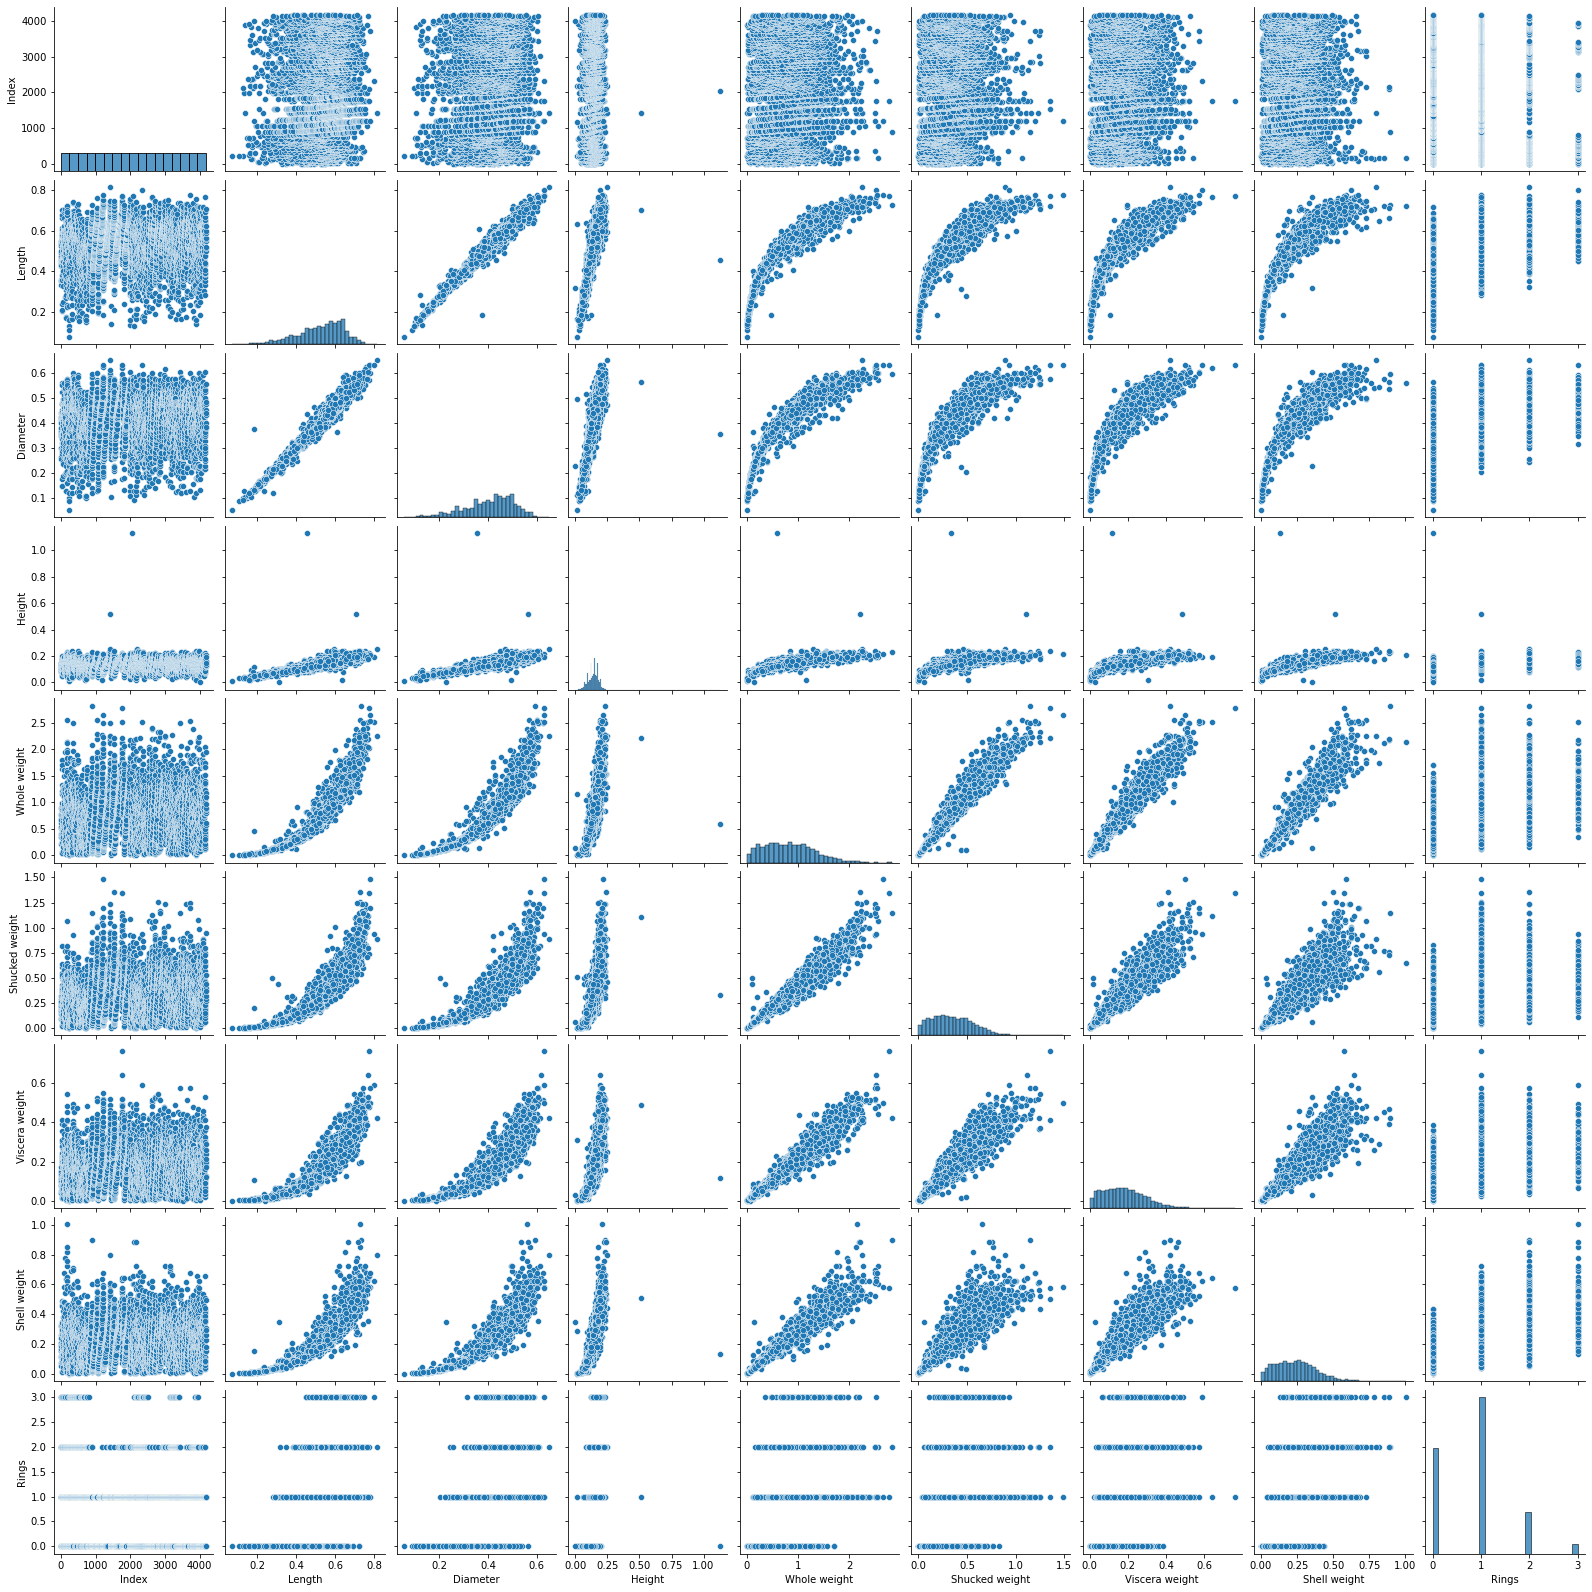

In [147]:
#compute pairplot

sns.pairplot(df)

Comment: regarding height column data are skewed. It would be helpful to do some preprocessing activities
The whole df is quite omogeneous, some distributions have some outliers but it's not a problematic situation.

<AxesSubplot:>

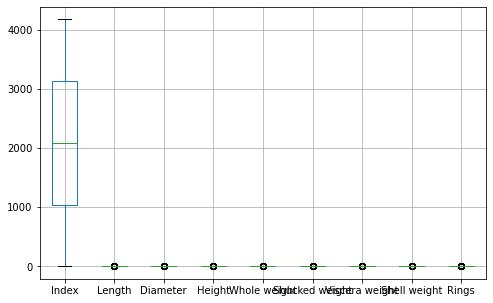

In [148]:
#compute boxplot
df.boxplot(grid=True,figsize=[8,5])

The main problem here is that we have data on a different range of values, index is not comparable, so let's split the visualization of them.

<AxesSubplot:>

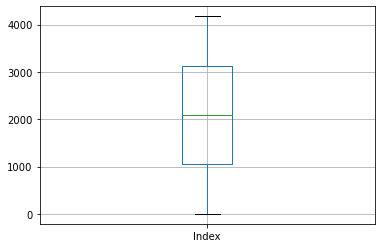

In [149]:
df.boxplot(column='Index')
#no outliers here

<AxesSubplot:>

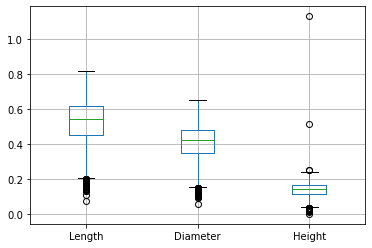

In [150]:
df.boxplot(column=['Length','Diameter','Height'])

Above we can see the presence of outliers in every column visualized.

<AxesSubplot:>

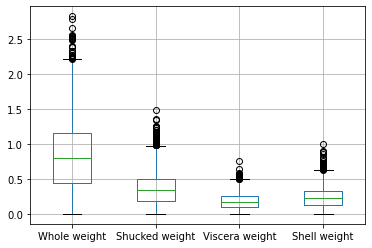

In [151]:
df.boxplot(column=['Whole weight','Shucked weight','Viscera weight','Shell weight'])

array([[<AxesSubplot:title={'center':'Index'}>,
        <AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Diameter'}>],
       [<AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Whole weight'}>,
        <AxesSubplot:title={'center':'Shucked weight'}>],
       [<AxesSubplot:title={'center':'Viscera weight'}>,
        <AxesSubplot:title={'center':'Shell weight'}>,
        <AxesSubplot:title={'center':'Rings'}>]], dtype=object)

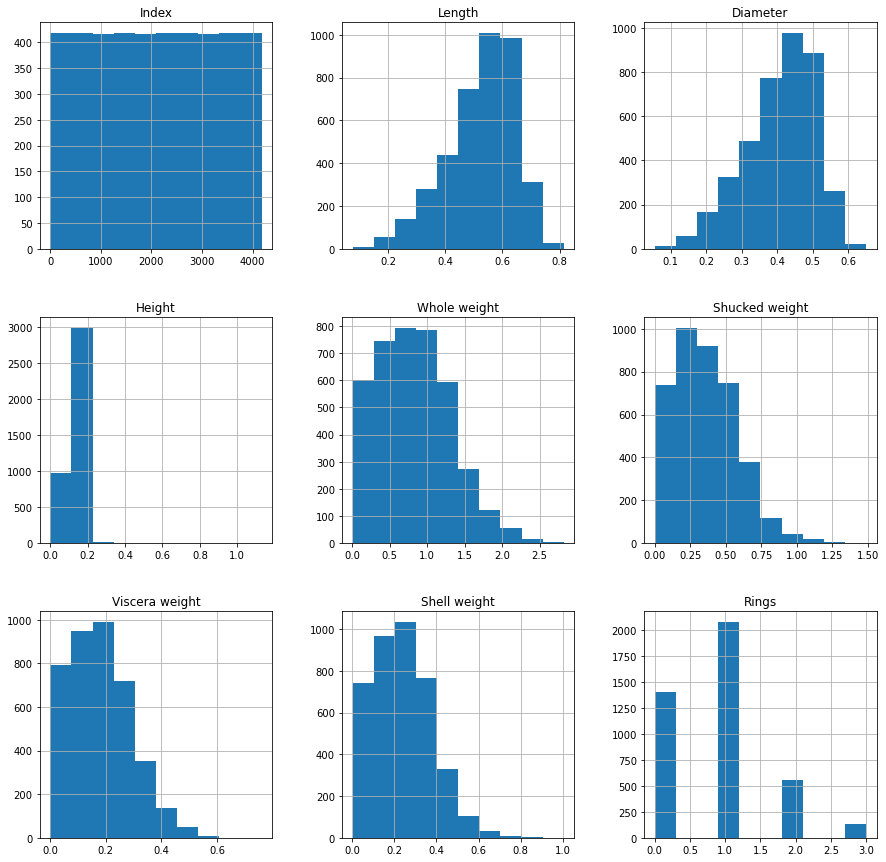

In [152]:
pd.DataFrame.hist(df, figsize = [15,15])

No major observation on the histograms, but again we can see the skewed distribution on height.

In [153]:
#We can drop unrelevant columns, in this case I would drop Sex
#it is non numeric

df1 = df.drop(columns='Sex')
df1.head()

,Index,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0
1,1,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0
2,2,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0
3,3,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0
4,4,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0


In [154]:
# Check for missing values
df1_null = df1.isnull()

# Count number of missing values in each column
null_count = df1_null.sum()
print(null_count)

#it's difficult to deal with these values, 
#in Index,Sex and Rings the situation is optimal, in the other cases the numbers are similar
#we could consider a zero value in this case but it may influence negatively our set
#for that reason we will drop null value rows

Index               0
Length            180
Diameter          201
Height            190
Whole weight      187
Shucked weight    194
Viscera weight    175
Shell weight      187
Rings               0
dtype: int64


In [155]:
df2 = df1.dropna().copy()
print("After dropping rows with nulls the dataset has {} rows".format(df2.shape[0]))

After dropping rows with nulls the dataset has 3052 rows


Now let's find a classification scheme using 2 methods.

In [156]:
#first of all we have to divide the target from the remaining dataset
X = df2.drop([target], axis = 1) # drop the class column
y = df2[target] # Class only

In [157]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state)

In [158]:
#instatiation of our models, we will use decision tree and knn

model_lbls = [
              'dt',  
             'knn',
            ]

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,20)]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
       },
}

scores = 'f1'

In [159]:
#function useful for printing results

def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [160]:
results_short={}

In [161]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
print("# Tuning hyper-parameters for %s" % scores)
print()

for m in model_lbls:
    print('-'*40)
    print("Trying model {}".format(models[m]['name']))
            
    clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                       scoring='%s_macro' % scores, 
                       return_train_score = False,
                       n_jobs = 2, # this allows using multi-cores
                        )

    clf.fit(X_train, y_train)
    print_results(clf)
    results_short[m] = clf.best_score_
    print("Summary of results for {}".format(scores))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:4.2}".format(models[m]['name'], results_short[m]))

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Decision Tree       
Best parameters set found on train set:

{'max_depth': 9}

Grid scores on train set:

0.356 (+/-0.017) for {'max_depth': 1}
0.455 (+/-0.031) for {'max_depth': 2}
0.442 (+/-0.015) for {'max_depth': 3}
0.449 (+/-0.013) for {'max_depth': 4}
0.481 (+/-0.017) for {'max_depth': 5}
0.489 (+/-0.038) for {'max_depth': 6}
0.495 (+/-0.060) for {'max_depth': 7}
0.500 (+/-0.052) for {'max_depth': 8}
0.502 (+/-0.047) for {'max_depth': 9}
0.499 (+/-0.058) for {'max_depth': 10}
0.500 (+/-0.060) for {'max_depth': 11}
0.500 (+/-0.051) for {'max_depth': 12}
0.497 (+/-0.052) for {'max_depth': 13}
0.495 (+/-0.041) for {'max_depth': 14}
0.489 (+/-0.052) for {'max_depth': 15}
0.493 (+/-0.061) for {'max_depth': 16}
0.488 (+/-0.062) for {'max_depth': 17}
0.496 (+/-0.066) for {'max_depth': 18}
0.491 (+/-0.053) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is

f1 has a range between 0 and 1, both decision tree and KNN has score 0.5, we can consider it good

In [164]:
#best values for dt is depth 11 or 12

#best value for knn is k_neighbor=1 

{'dt': 0.5024443964950206,
 'knn': 0.5044596719980718,
 'DecisionTree': 0.5010172303966668}

In [168]:
#Now compute classification report for both models
top_par_cv = 11
estimator = tree.DecisionTreeClassifier(criterion="entropy", max_depth = top_par_cv)
estimator.fit(X_train,y_train);
y_predicted = estimator.predict(X_test)
accuracy_cv = accuracy_score(y_test, y_predicted) * 100
print("The accuracy on TEST set tuned with cross_validation for Decision Tree is {:.1f}% with depth {}".format(accuracy_cv, top_par_cv))

print(confusion_matrix(y_test,y_predicted))

The accuracy on TEST set tuned with cross_validation for Decision Tree is 63.4% with depth 11
[[159  59   2   0]
 [ 68 239  56   4]
 [  6  52  83  15]
 [  0   3  14   3]]


In [169]:
#KNN
estimator = KNeighborsClassifier(1)
estimator.fit(X_train,y_train);
y_predicted = estimator.predict(X_test)
accuracy_cv = accuracy_score(y_test, y_predicted) * 100
print("The accuracy on TEST set tuned with cross_validation is {:.1f}% with {} neighbor".format(accuracy_cv,1))

print(confusion_matrix(y_test,y_predicted))

The accuracy on TEST set tuned with cross_validation is 58.7% with 1 neighbor
[[157  57   6   0]
 [ 76 216  62  13]
 [ 11  65  69  11]
 [  2   3   9   6]]


Both models have a similar output, Decision tree is better for a small amount

Regarding confusion matrix, they are similar too, on the main diagonal the number of correct classification is similar, but KNN
makes more mistakes in some cases.